# Julia OpenCL

In [1]:
versioninfo()

Julia Version 0.5.1
Commit 6445c82 (2017-03-05 13:25 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel Xeon E312xx (Sandy Bridge)
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Sandybridge)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, sandybridge)


In this notebook we will look at implementing a diffusion equation in Julia, first in native terms and then using Julia’s OpenCL bindings.

## A note on multi-dimensional arrays

Julia’s multi-dimensional arrays are stored in column-major order (and indexed starting at 1) just like Fortran, whereas array handling in OpenCL are stored in row-major order

## The heat equation
The first system that we want to investigate is the heat or diffusion equation, it is given by the following differential equation:

\begin{align}
  \frac{\partial}{\partial t}u - \alpha \nabla^2u &= 0
\end{align}


In order for Julia’s JIT optimiser to work properly, every calculation should be wrapped inside a function for maximum speed.

We start with our initial state. For simplicity, we’ll take a rectangular matrix of zeros and fix the centre at a value of 10.

In [2]:
""" Returns the initial state. """
function initial_state(height, width)
    initial = zeros(Float32, height, width)
    # Pick the center
    # Since Julia starts indexing with 1, we use cls to divide and round up
    initial[cld(height, 2), cld(width, 2)] = 10.0
    initial
end    

initial_state

In [3]:
# example
initial_state(5, 5)

5×5 Array{Float32,2}:
 0.0  0.0   0.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0
 0.0  0.0  10.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0

We use a two-step algorithm. First we iterate through the initial matrix, take the first-order laplacian of each point and copy this to a matrix of the same size

In [4]:
function diff_step!(source, diff)
    
    # I am pretty sure this can be solved more elegantly
    # but by using the CartesianIndex we avoid having to calculate the
    # row and col index ourselves.        
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    neighborsCartesian = map(x -> CartesianIndex{2}(x), neighbors)

    for i in CartesianRange(size(source))
        diff[i] = - 4 * source[i]
        for c in neighborsCartesian
            idx = i + c
            # need to use mod1 here because of 1-indexing
            diff[i] += source[CartesianIndex{2}(mod1(idx.I[1], size(source)[1]), mod1(idx.I[2], size(source)[2]))]
        end
    end
end

diff_step! (generic function with 1 method)

Afterwards, we multiply the matrix of differences with our step size and add the result to our source matrix.

In [5]:
function add_step!(source, diff, step_size::Float32)
    # The dot-operator signifies broadcasting:
    # Julia will not create an intermediate array but
    # use the equivalent of a for loop to perform
    # everything in-place.
    source .+= step_size * diff
end

add_step! (generic function with 1 method)

Now it is just iterating over the number of steps. Note that we also create the diff matrix in advance.

In [6]:
function do_native(initial, step_size::Float32, num_steps)
    diff = similar(initial)
    for s in 1:num_steps
        diff_step!(initial, diff)
        add_step!(initial, diff, step_size)
    end
    initial
end

do_native (generic function with 1 method)

Now, let’s print the result after 100 steps.

In [7]:
init = initial_state(500, 500)
@time res = do_native(init, Float32(0.01), 1000)

 28.303300 seconds (242.21 k allocations: 1.874 GB, 0.25% gc time)


500×500 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [8]:
#Pkg.add("BenchmarkTools")
using BenchmarkTools

In [9]:
@benchmark do_native(init, Float32(0.01), 100)

BenchmarkTools.Trial: 
  memory estimate:  191.76 MiB
  allocs estimate:  1802
  --------------
  minimum time:     2.955 s (0.00% GC)
  median time:      2.960 s (0.00% GC)
  mean time:        2.960 s (0.00% GC)
  maximum time:     2.966 s (0.00% GC)
  --------------
  samples:          2
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [10]:
using PyPlot

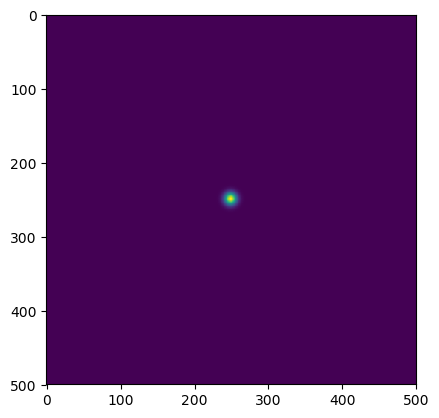

PyObject <matplotlib.image.AxesImage object at 0x7efc09ead610>

In [11]:
PyPlot.imshow(res)

If PyPlot does not work, execute the following:

In [12]:
#ENV["PYTHON"] = ""
#Pkg.build("PyCall")

## OpenCL

First step: import OpenCL and check whether we have devices we can use it on.

In [13]:
using OpenCL
cl.devices()

1-element Array{OpenCL.cl.Device,1}:
 OpenCL.Device(Intel Xeon E312xx (Sandy Bridge) on Intel(R) OpenCL @0x000000001e9fa6e8)

In [14]:
diff_kernel = """
int mod(int a, int b)
{
    if (b < 0) return mod(a, -b);   
    int ret = a % b;
    if (ret < 0)
        ret += b;
    return ret;
}

__kernel void diff2d(
    __global const float *matrix,
    __global float *diff)
{
    int gidx = get_global_id(0);
    int gidy = get_global_id(1);
    int maxx = get_global_size(0);
    int maxy = get_global_size(1);

#ifdef __APPLE__
    float (*b)[maxy] = (float(*)[maxy]) matrix;
    float (*d)[maxx] = (float(*)[maxx]) diff;

    d[gidx][gidy] = - 4. * b[gidx][gidy]
        + b[mod(gidx - 1, maxx][gidy]
        + b[mod(gidx + 1, maxx][gidy]
        + b[gidx][mod(gidy - 1, maxy)]
        + b[gidx][mod(gidy + 1, maxy)];
#else
    diff[gidx + gidy * maxx] = - 4. * matrix[gidx + gidy * maxx]
        + matrix[mod(gidx - 1, maxx) + gidy * maxx]
        + matrix[mod(gidx + 1, maxx) + gidy * maxx]
        + matrix[gidx + mod(gidy - 1, maxy) * maxx]
        + matrix[gidx + mod(gidy + 1, maxy) * maxx];
#endif
}
""";

In [15]:
sum_kernel = """
__kernel void sum(
    __global float *matrix,
    __global const float *diff,
    float step_size)
{
    int gid = get_global_id(0);
    matrix[gid] += step_size * diff[gid];
}
""";

In [16]:
using OpenCL

In [17]:
function do_openCL2d(input, step_size, num_steps)
    device, ctx, queue = cl.create_compute_context()
    #print(device, ctx, queue)
    input_buff = cl.Buffer(Float32, ctx, (:rw, :copy), hostbuf=input)
    diff_buff = cl.Buffer(Float32, ctx, :rw, length(input))

    program = cl.Program(ctx, source=diff_kernel * sum_kernel) |> cl.build!

    diff_k = cl.Kernel(program, "diff2d")
    sum_k = cl.Kernel(program, "sum")
    #@printf "%p" input_buff
    #@printf "%p" diff_buff

    for i in 1:num_steps
        queue(diff_k, size(input), nothing, input_buff, diff_buff)
        queue(sum_k, length(input), nothing, input_buff, diff_buff, Float32(step_size))
    end
    r = cl.read(queue, input_buff);
    r = reshape(r, size(input))
    return r
end

do_openCL2d (generic function with 1 method)

In [21]:
init = initial_state(500, 500)
@time res = do_openCL2d(init, Float32(0.01), 1000)

  0.473729 seconds (76.19 k allocations: 3.467 MB)


500×500 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [19]:
@benchmark do_openCL2d(init, Float32(0.01), 100)

BenchmarkTools.Trial: 
  memory estimate:  1.21 MiB
  allocs estimate:  7784
  --------------
  minimum time:     64.478 ms (0.00% GC)
  median time:      101.232 ms (0.00% GC)
  mean time:        100.523 ms (0.00% GC)
  maximum time:     280.295 ms (0.00% GC)
  --------------
  samples:          50
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

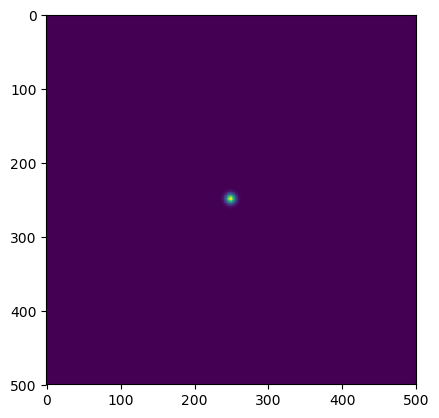

PyObject <matplotlib.image.AxesImage object at 0x7efb98e1f6d0>

In [22]:
PyPlot.imshow(res)